In [43]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import tqdm
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec
from sklearn.cluster import OPTICS
%matplotlib inline

In [75]:
# Hand pick some stocks

tech = ['AAPL', 'AMZN', 'GOOGL', 'INTC', 'NVDA', 'NFLX', 'MSFT', 'META', 'ORCL', 'UBER']
food_drink = ['MCD', 'SBUX', 'PEP', 'KO', 'NSRGF', 'KHC', 'BUD', 'HSY', 'GIS']
biotech = ['PFE', 'MRK', 'AMGN', 'JNJ', 'GILD', 'BMY', 'AZN', 'LLY', 'ABBV']
energy = ['XOM', 'CVX', 'BP', 'TTE', 'SHEL', 'COP', 'SLB', 'PSX', 'HAL', 'E']
real_estate = ['SPG', 'PLD', 'AMT', 'PSA', 'EQIX', 'WELL', 'AVB', 'O', 'DLR', 'VTR']

list_of_stocks = real_estate + tech + food_drink + biotech + energy


In [45]:
def index_to_label(idx):
  return

In [76]:
sd = datetime(2020, 5, 6) 
ed = datetime(2023, 5, 5)
stocks = {}
stocks_array = np.zeros((len(list_of_stocks), 755))

for i in range(len(list_of_stocks)):
  label = list_of_stocks[i]
  stocks[label] = yf.download(tickers=label, start=sd, end=ed, interval="1d")
  stocks_array[i] = stocks[label]['Adj Close'].to_numpy().flatten()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [47]:
print(stocks['AAPL'])
print(stocks['AMZN'].to_numpy().shape)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-05-06   75.114998   75.809998   74.717499   75.157501   73.692352   
2020-05-07   75.805000   76.292503   75.492500   75.934998   74.454681   
2020-05-08   76.410004   77.587502   76.072502   77.532501   76.226830   
2020-05-11   77.025002   79.262497   76.809998   78.752502   77.426285   
2020-05-12   79.457497   79.922501   77.727501   77.852501   76.541435   
...                ...         ...         ...         ...         ...   
2023-04-28  168.490005  169.850006  167.880005  169.679993  169.679993   
2023-05-01  169.279999  170.449997  168.639999  169.589996  169.589996   
2023-05-02  170.089996  170.350006  167.539993  168.539993  168.539993   
2023-05-03  169.500000  170.919998  167.160004  167.449997  167.449997   
2023-05-04  164.889999  167.039993  164.309998  165.789993  165.789993   

               Volume  
Date         

In [77]:
normalized_stocks_array = np.zeros(stocks_array.shape)
for i in range(len(list_of_stocks)):
  normalized_stocks_array[i, 0] = 0
  for j in range(1, 755):
    normalized_stocks_array[i, j] = (stocks_array[i, j] - stocks_array[i, j-1]) / stocks_array[i, j-1]

In [78]:
pca = PCA(n_components=15)
reduced_stock_array = pca.fit_transform(normalized_stocks_array)

In [79]:
print(reduced_stock_array.shape)

(48, 15)


In [80]:
optics_clustering = OPTICS(min_samples=3).fit(reduced_stock_array)
print(optics_clustering.labels_)

[-1  0  0  0  0 -1 -1 -1  0 -1  3  3  3 -1 -1 -1  3 -1 -1 -1  1 -1  1  1
 -1  1 -1  1  1 -1  2  2  2  2  2 -1 -1  2  5  5  4  4  4  5 -1  5 -1  4]


Cluster 0 contains ['PLD', 'AMT', 'PSA', 'EQIX', 'DLR']
Cluster 1 contains ['MCD', 'PEP', 'KO', 'KHC', 'HSY', 'GIS']
Cluster 2 contains ['MRK', 'AMGN', 'JNJ', 'GILD', 'BMY', 'ABBV']
Cluster 3 contains ['AAPL', 'AMZN', 'GOOGL', 'MSFT']
Cluster 4 contains ['BP', 'TTE', 'SHEL', 'E']


Text(0.5, 1.0, 'Automatic Clustering\nOPTICS')

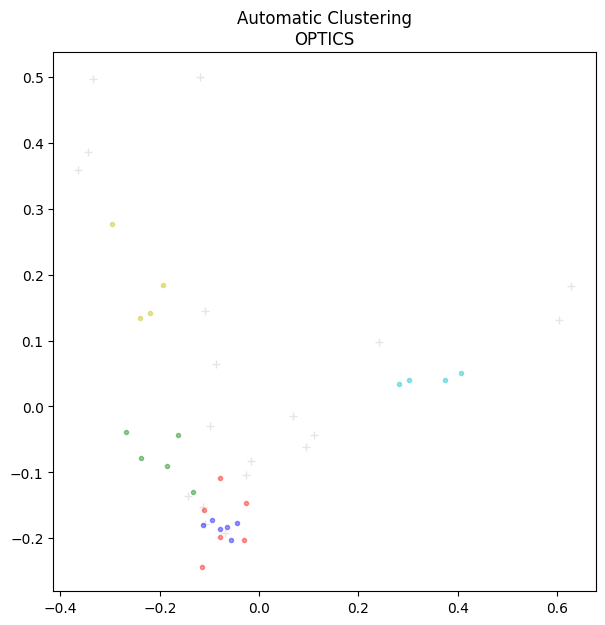

In [81]:
plt.figure(figsize=(7, 7))
G = gridspec.GridSpec(1, 1)
ax2 = plt.subplot(G[0, 0])
clusters = []

colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = reduced_stock_array[optics_clustering.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.4)
    indices = [i for i, x in enumerate(optics_clustering.labels_) if x == klass]
    cur_list = [list_of_stocks[i] for i in indices]
    clusters.append(cur_list)
    print(f'Cluster {klass} contains {cur_list}')
ax2.plot(reduced_stock_array[optics_clustering.labels_ == -1, 0], reduced_stock_array[optics_clustering.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

In [82]:
def get_common_dates(stock1, stock2):
    return list(set(stock1.index.tolist()).intersection(set(stock2.index.tolist())))

In [83]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

In [84]:
def reg(stock1_common, stock2_common):
    price1, price2 = np.array(stock1_common['Adj Close']), np.array(stock2_common['Adj Close'])
    logprice1, logprice2 = np.log(price1), np.log(price2)
    lin_reg = LinearRegression(fit_intercept=True)
    lin_reg.fit(logprice1.reshape(-1, 1), logprice2)
    beta, alpha = lin_reg.coef_[0], lin_reg.intercept_
    spread = logprice2 - beta * logprice1 - alpha
    
    return spread

In [85]:
def ADFTest(spread):
    adf = sm.tsa.stattools.adfuller(spread, maxlag=1)
    print('ADF test statistic: %.02f' % adf[0])
    for key, value in adf[4].items():
        print('\t%s: %.3f' % (key, value))
    print('p-value: %.03f' % adf[1])
    return adf[1]

In [86]:
def half_life(spread):
    z_lag = np.roll(spread,1)
    z_lag[0] = 0
    z_ret = spread - z_lag
    z_ret[0] = 0
   
    # adds intercept terms to X variable for regression
    z_lag2 = sm.add_constant(z_lag)

    # model = sm.OLS(z_ret,z_lag2)
    # res = model.fit()

    z_lag2 = sm.add_constant(z_lag)

    model = sm.OLS(z_ret,z_lag2)
    res = model.fit()

    # lin_reg = LinearRegression(fit_intercept=True)
    # lin_reg.fit(z_lag.reshape(-1, 1), z_ret)

    # halflife = np.log(0.5) / lin_reg.coef_[0]
    halflife = -np.log(2) / res.params[1]
    # print(res.params[1])

    return halflife


In [87]:
def num_of_hitting_zero(spread):
  count = 0
  for i in range(spread.shape[0] - 1):
    if spread[i] * spread[i+1] < 0:
      count += 1
  print(f'Hit zero {count} times')
  return count

In [88]:
def testPair(stock1_name, stock2_name, sd, ed):
    ENDC = '\033[0m'
    PASS = '\033[92m'
    FAIL = '\033[91m'
    stock1 = yf.download(tickers=stock1_name, start=sd, end=ed, interval="1d")
    stock2 = yf.download(tickers=stock2_name, start=sd, end=ed, interval="1d")  
    common_dates = sorted(get_common_dates(stock1, stock2))
    stock1_common, stock2_common = stock1.loc[common_dates], stock2.loc[common_dates]
    spread = reg(stock1_common, stock2_common)
    
    ADF_p_value = ADFTest(spread)
    # plt.plot(common_dates, spread)
    if ADF_p_value > 0.05:
        print("\033[91mNot a Pair!" + ENDC)
        return False, (stock1_name, stock2_name)
    hurst_exponent = get_hurst_exponent(spread)
    print(f'Hurst exponent is {hurst_exponent}')
    if hurst_exponent > 0.5:
        print(FAIL + "Not a Pair!" + ENDC)
        return False, (stock1_name, stock2_name)
    print(f'Half life of mean reversion is {half_life(spread)}')
    if half_life(spread) < 1 or half_life(spread) > 365:
        print(FAIL + "Not a Pair!" + ENDC)
        return False, (stock1_name, stock2_name)
    if num_of_hitting_zero(spread) < 12*3:
        print(FAIL + "Not a Pair!" + ENDC)
        return False, (stock1_name, stock2_name)
    print(PASS + stock1_name + " and " + stock2_name + " are indeed a pair!" + ENDC)
    return True, (stock1_name, stock2_name)
    
    


In [73]:
testPair('KO', 'HSY', sd, ed)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ADF test statistic: -3.07
	1%: -3.439
	5%: -2.865
	10%: -2.569
p-value: 0.029
Hurst exponent is 0.4508057199987197
Half life of mean reversion is 25.687085550247776
Hit zero 60 times
KO and HSY are indeed a pair!


(True, ('KO', 'HSY'))

In [89]:
counter = 0
pair_counter = 0
pairs = []
for cluster in clusters:
  for i in range(len(cluster)):
    for j in range(len(cluster)):
      if i < j:
        counter += 1
        areTheyPair, pair = testPair(cluster[i], cluster[j], sd, ed)
        if areTheyPair:
          pair_counter += 1
          pairs.append(pair)
print(f'{counter} potential pairs are tested, {pair_counter} actual pairs are found')
for pair in pairs:
  print(pair)
          



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ADF test statistic: -1.55
	1%: -3.439
	5%: -2.865
	10%: -2.569
p-value: 0.511
Not a Pair!
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ADF test statistic: -2.45
	1%: -3.439
	5%: -2.865
	10%: -2.569
p-value: 0.128
Not a Pair!
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ADF test statistic: -2.60
	1%: -3.439
	5%: -2.865
	10%: -2.569
p-value: 0.094
Not a Pair!
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ADF test statistic: -1.04
	1%: -3.439
	5%: -2.865
	10%: -2.569
p-value: 0.739
Not a Pair!
[*********************100%***********************]  1 of 1 completed
[******************

## Prepare training / test data

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

def normalize_spread(data, scaler):
    scaled_data = scaler.fit_transform(data.reshape(-1,1))
    return scaled_data


def train_test_split(dates, data, test_ratio=0.1, window_size=30):
    assert len(dates) == len(data)
    test_size = int(len(dates) * test_ratio)
    train_size = len(dates) - test_size
    X_train, y_train, X_test, y_test = [], [], [], []
    for i in range(window_size, train_size):
        X_train.append(data[i - window_size:i])
        y_train.append(data[i])
    for i in range(train_size + window_size, train_size + test_size):
        X_test.append(data[i - window_size:i])
        y_test.append(data[i])
    print(f"Finishing splitting, training size: {len(X_train)}, testing size: {len(X_test)}")
    
    return X_train, y_train, X_test, y_test, dates[:train_size], dates[train_size:]

def to_dataloader(X_train, y_train, X_test, y_test, batch_size):
    train_set = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    train_loader = DataLoader(train_set, batch_size=batch_size)
    test_set = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
    test_loader = DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

scaled_spread = normalize_spread(spread, scaler)
X_train, y_train, X_test, y_test, train_dates, test_dates = train_test_split(common_dates, scaled_spread)
train_loader, test_loader = to_dataloader(X_train, y_train, X_test, y_test, batch_size=8)

Finishing splitting, training size: 650, testing size: 45


## LSTM Model

In [ ]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Define the training function
def train(model, train_loader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if (i+1) % 40 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# Train the model
input_dim = 1
hidden_dim = 10
output_dim = 1
num_layers = 2
learning_rate = 0.001
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
train(model, train_loader, num_epochs, learning_rate)

Epoch [1/100], Step [40/82], Loss: 0.0071
Epoch [1/100], Step [80/82], Loss: 0.0054
Epoch [2/100], Step [40/82], Loss: 0.0156
Epoch [2/100], Step [80/82], Loss: 0.0048
Epoch [3/100], Step [40/82], Loss: 0.0146
Epoch [3/100], Step [80/82], Loss: 0.0047
Epoch [4/100], Step [40/82], Loss: 0.0105
Epoch [4/100], Step [80/82], Loss: 0.0047
Epoch [5/100], Step [40/82], Loss: 0.0043
Epoch [5/100], Step [80/82], Loss: 0.0014
Epoch [6/100], Step [40/82], Loss: 0.0013
Epoch [6/100], Step [80/82], Loss: 0.0012
Epoch [7/100], Step [40/82], Loss: 0.0006
Epoch [7/100], Step [80/82], Loss: 0.0021
Epoch [8/100], Step [40/82], Loss: 0.0004
Epoch [8/100], Step [80/82], Loss: 0.0023
Epoch [9/100], Step [40/82], Loss: 0.0004
Epoch [9/100], Step [80/82], Loss: 0.0026
Epoch [10/100], Step [40/82], Loss: 0.0004
Epoch [10/100], Step [80/82], Loss: 0.0028
Epoch [11/100], Step [40/82], Loss: 0.0004
Epoch [11/100], Step [80/82], Loss: 0.0030
Epoch [12/100], Step [40/82], Loss: 0.0005
Epoch [12/100], Step [80/82],

Epoch [96/100], Step [80/82], Loss: 0.0016
Epoch [97/100], Step [40/82], Loss: 0.0003
Epoch [97/100], Step [80/82], Loss: 0.0015
Epoch [98/100], Step [40/82], Loss: 0.0003
Epoch [98/100], Step [80/82], Loss: 0.0015
Epoch [99/100], Step [40/82], Loss: 0.0003
Epoch [99/100], Step [80/82], Loss: 0.0015
Epoch [100/100], Step [40/82], Loss: 0.0003
Epoch [100/100], Step [80/82], Loss: 0.0015


Total MSE loss: 7.680168346269056e-05


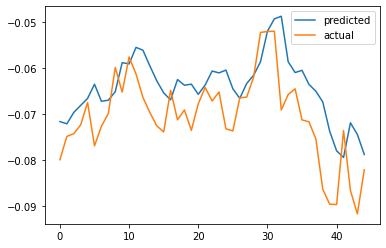

In [ ]:
def test(model, test_loader):
    predictions = []
    batch_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
            batch_labels.append(labels.numpy())
    return predictions, batch_labels

predictions, labels = test(model, test_loader)
predictions = scaler.inverse_transform(np.concatenate(predictions)).flatten()
labels = scaler.inverse_transform(np.concatenate(labels)).flatten()
# # # Visualize the results

plt.plot(predictions, label='predicted')
plt.plot(labels, label='actual')
print(f'Total MSE loss: {mean_squared_error(predictions, labels)}')
plt.legend()
plt.show()